In [1]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
from smt.sampling_methods import LHS
#from torch import linspace
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import time

from E_data import IC,BC_L,BC_R,BD_circle
from E_Plotting import E_plot,  loss_plot 

# Full PINN
from E_PINN import NN
from E_PINN_train import pinn_train

# VGPT-PINN
from E_VGPT_activation import P

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

torch.manual_seed(123)
np.random.seed(123)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [2]:
lr = 0.001                                                           # Learning rate
num_ib = 15000                                                # Random sampled points from IC0
num_int = 300000                                                # Random sampled points in interior
Tend = 0.4
Lx = 1.5
Ly = 2.0
rx = 1.0
ry = 1.0
rd = 0.25

xlimits = np.array([[0.,Tend],[0.0, Lx], [0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)
A = []
for i in range(num_int):
    x = x_int_train[i,1]
    y = x_int_train[i,2]
    if ((x - rx)**2 +(y-ry)**2< rd**2):
        A.append(i)
x_int_train = np.delete(x_int_train,A,axis=0)

xlimits = np.array([[0.,0.0],[0.0,Lx], [0.0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic_train = sampling(num_ib)
A = []
for i in range(num_ib):
    x = x_ic_train[i,1]
    y = x_ic_train[i,2]
    if ((x - rx)**2 +(y-ry)**2< rd**2):
        A.append(i)
x_ic_train = np.delete(x_ic_train,A,axis=0)


xlimits = np.array([[0.0,Tend],[0.0, 0.0], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcL_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [Lx, Lx], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcR_train =  sampling(num_ib)


xlimits = np.array([[0.0,Tend],[0.0, Lx], [Ly,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcU_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [0.0, Lx], [0.0,0.0]])
sampling = LHS(xlimits=xlimits)
x_bcD_train =  sampling(num_ib)                                           # Vectorized whole domain

x_bcI_train,sin_bcI_train,cos_bcI_train = BD_circle(Tend,rx,ry,rd,num_ib)

rho_bcL_train, u_bcL_train,v_bcL_train, p_bcL_train = BC_L(x_bcL_train)  
rho_bcR_train, u_bcR_train,v_bcR_train, p_bcR_train = BC_L(x_bcR_train)  
rho_ic_train, u_ic_train,v_ic_train, p_ic_train = IC(x_ic_train)  


x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_bcL_train = torch.tensor(rho_bcL_train, dtype=torch.float32).to(device)
u_bcL_train = torch.tensor(u_bcL_train, dtype=torch.float32).to(device)
v_bcL_train = torch.tensor(v_bcL_train, dtype=torch.float32).to(device)
p_bcL_train = torch.tensor(p_bcL_train, dtype=torch.float32).to(device)

rho_bcR_train = torch.tensor(rho_bcR_train, dtype=torch.float32).to(device)
u_bcR_train = torch.tensor(u_bcR_train, dtype=torch.float32).to(device)
v_bcR_train = torch.tensor(v_bcR_train, dtype=torch.float32).to(device)
p_bcR_train = torch.tensor(p_bcR_train, dtype=torch.float32).to(device)

x_bcD_train = torch.tensor(x_bcD_train,requires_grad=True, dtype=torch.float32).to(device)
x_bcU_train = torch.tensor(x_bcU_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcR_train = torch.tensor(x_bcR_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcL_train = torch.tensor(x_bcL_train, dtype=torch.float32).to(device)
x_bcI_train = torch.tensor(x_bcI_train, requires_grad=True, dtype=torch.float32).to(device)
sin_bcI_train = torch.tensor(sin_bcI_train, dtype=torch.float32).to(device)
cos_bcI_train = torch.tensor(cos_bcI_train, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
v_ic_train = torch.tensor(v_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)

Epoch: 0 | Loss: 324.50579833984375
Epoch: 100 | Loss: 0.381522
Epoch: 200 | Loss: 0.279190
Epoch: 300 | Loss: 0.243141
Epoch: 400 | Loss: 0.222505
Epoch: 500 | Loss: 0.206351
Epoch: 600 | Loss: 0.194183
Epoch: 700 | Loss: 0.184700
Epoch: 800 | Loss: 0.175974
Epoch: 900 | Loss: 0.168427
Epoch: 1000 | Loss: 0.162168
Epoch: 1100 | Loss: 0.156377
Epoch: 1200 | Loss: 0.151735
Epoch: 1300 | Loss: 0.147785
Epoch: 1400 | Loss: 0.144165
Epoch: 1500 | Loss: 0.140631
Epoch: 1600 | Loss: 0.137508
Epoch: 1700 | Loss: 0.134763
Epoch: 1800 | Loss: 0.131879
Epoch: 1900 | Loss: 0.129779
Epoch: 2000 | Loss: 0.127703
Epoch: 2100 | Loss: 0.125857
Epoch: 2200 | Loss: 0.124202
Epoch: 2300 | Loss: 0.122541
Epoch: 2400 | Loss: 0.121174
Epoch: 2500 | Loss: 0.119548
Epoch: 2600 | Loss: 0.118141
Epoch: 2700 | Loss: 0.116907
Epoch: 2800 | Loss: 0.115680
Epoch: 2900 | Loss: 0.114493
Epoch: 3000 | Loss: 0.113472
Epoch: 3100 | Loss: 0.112521
Epoch: 3200 | Loss: 0.111545
Epoch: 3300 | Loss: 0.110601
Epoch: 3400 | Lo

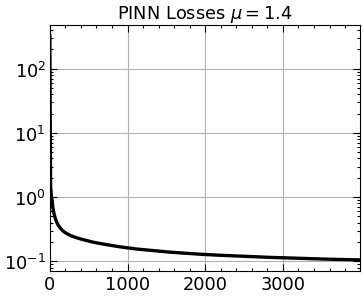

In [3]:
lr = 0.001
nu_pinn_train = 1.4
layers_pinn = np.array([3, 90,90,90,90,90,90, 4])

lr_pinn     = 0.001
epochs_pinn = 4000
tol_pinn    = 1e-2

pinn_train_time_1 = time.perf_counter()
PINN = NN(nu_pinn_train, layers_pinn, gamma=nu_pinn_train).to(device)
    
pinn_losses = pinn_train(PINN, nu_pinn_train, x_int_train,x_ic_train,rho_ic_train,u_ic_train,v_ic_train,p_ic_train,x_bcL_train, rho_bcL_train,u_bcL_train,v_bcL_train,p_bcL_train,x_bcI_train, sin_bcI_train,cos_bcI_train, epochs_pinn, lr_pinn, tol_pinn)

pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")
loss_plot(pinn_losses[1], pinn_losses[0], dpi=80, figsize=(5,4),title=fr"PINN Losses $\mu={round(nu_pinn_train,3)}$")

In [4]:
%run E_TGPT_activation.py
P_list = np.ones(1, dtype=object)
w1 = PINN.linears[0].weight.detach().cpu()
w2 = PINN.linears[1].weight.detach().cpu()
w3 = PINN.linears[2].weight.detach().cpu()
w4 = PINN.linears[3].weight.detach().cpu()
w5 = PINN.linears[4].weight.detach().cpu()
w6 = PINN.linears[5].weight.detach().cpu()
w7 = PINN.linears[6].weight.detach().cpu()

b1 = PINN.linears[0].bias.detach().cpu()
b2 = PINN.linears[1].bias.detach().cpu()
b3 = PINN.linears[2].bias.detach().cpu()
b4 = PINN.linears[3].bias.detach().cpu()
b5 = PINN.linears[4].bias.detach().cpu()
b6 = PINN.linears[5].bias.detach().cpu()
b7 = PINN.linears[6].bias.detach().cpu()

# Add new activation functions
P_list[0]= P(layers_pinn, w1, w2, w3, w4, w5,w6,w7, b1, b2, b3, b4,b5,b6,b7).to(device)

import pickle 
with open('PINN_Euler_circle025_loss.pkl', 'wb') as f:
        pickle.dump(P_list, f)

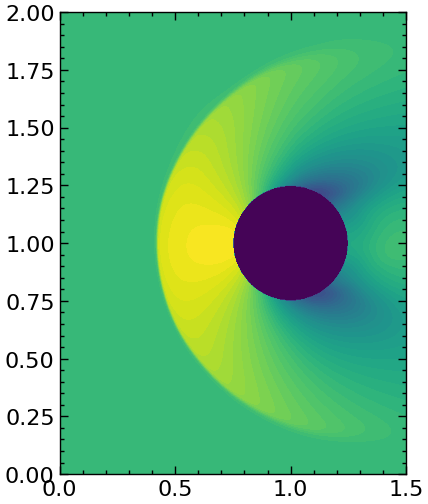

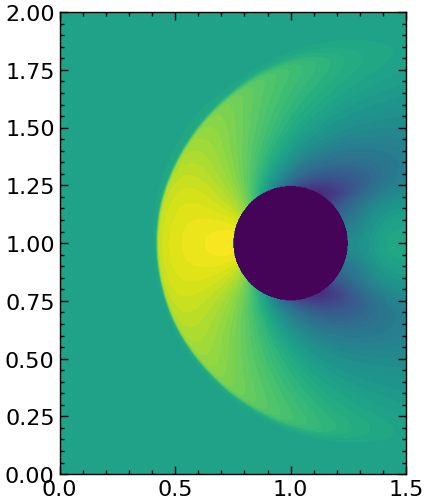

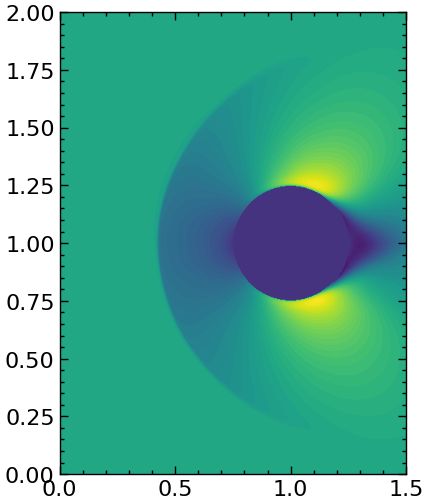

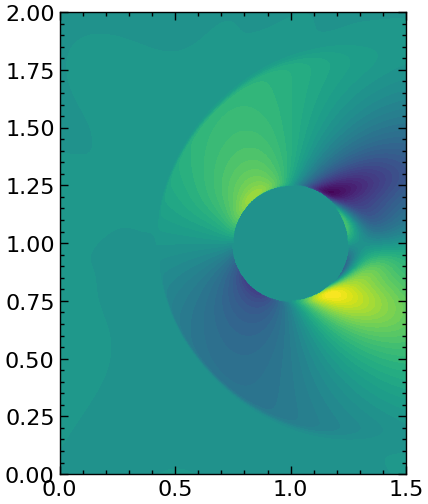

In [5]:
Nd = 600
T = 0.4
t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(PINN(x_test))


x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0          
uo1 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,1]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo2 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()  

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,2]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo3 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()

ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,3]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo4 = ue.flatten()[:,None]
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()